In [2]:
# CSCI441 Project
# SectionI: Code
# Made by Yousef Kahwaji, Ahmad Akoum, and Mohammad Al Dirani

In [3]:
import math

#recurring imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
#fetching dataset from yfinance
import yfinance as yf
nvda = yf.Ticker("NVDA")
df = nvda.history(period="max")
df.drop(columns=["Dividends",'Stock Splits'], inplace=True) #remove meaningless columns

In [5]:
#engineering meaningful columns. All engineered columns are explained in the report/ppt

from ta.momentum import RSIIndicator
from ta.trend import MACD

#SMA 20,50,100,200. Simple Moving Average.
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

#distance from trend, using sma
df['Close_SMA20_diff']  = df['Close'] / df['SMA_20'] - 1
df['Close_SMA50_diff']  = df['Close'] / df['SMA_50'] - 1
df['Close_SMA100_diff'] = df['Close'] / df['SMA_100'] - 1
df['Close_SMA200_diff'] = df['Close'] / df['SMA_200'] - 1

#RSI 14,30,90. Relative Strength Index. (momentum)
df['RSI14'] = RSIIndicator(close=df['Close'], window=14).rsi()
df['RSI30'] = RSIIndicator(close=df['Close'], window=30).rsi()
df['RSI90'] = RSIIndicator(close=df['Close'], window=90).rsi()

#rate of change. ROC. kinda momentum
df['ROC_5']  = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)
df['ROC_20'] = df['Close'].pct_change(20)

#Volatility
df['Vol_5']  = df['Close'].pct_change().rolling(5).std()
df['Vol_10'] = df['Close'].pct_change().rolling(10).std()
df['Vol_20'] = df['Close'].pct_change().rolling(20).std()

#Price Structure (to prevent future leakage)
df['HL_range'] = (df['High'] - df['Low']) / df['Close']
df['OC_range'] = (df['Open'] - df['Close']) / df['Close']

#Trend confirmation
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

#Days and months for pattern recognition
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

#display all columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6779 entries, 1999-01-22 00:00:00-05:00 to 2026-01-02 00:00:00-05:00
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6779 non-null   float64
 1   High               6779 non-null   float64
 2   Low                6779 non-null   float64
 3   Close              6779 non-null   float64
 4   Volume             6779 non-null   int64  
 5   SMA_20             6760 non-null   float64
 6   SMA_50             6730 non-null   float64
 7   SMA_100            6680 non-null   float64
 8   SMA_200            6580 non-null   float64
 9   Close_SMA20_diff   6760 non-null   float64
 10  Close_SMA50_diff   6730 non-null   float64
 11  Close_SMA100_diff  6680 non-null   float64
 12  Close_SMA200_diff  6580 non-null   float64
 13  RSI14              6766 non-null   float64
 14  RSI30              6750 non-null   float64
 15  RSI90              6690 

In [6]:
#Finalizing the dataset for usage

#Creating Output with threshold to remove noise
df_2 = df.copy()
threshold = 0.005  # 0.5%
df_2['Change'] = np.where((df['Close'].shift(-1) / df['Close'] - 1) > threshold,'UP','DOWN')
df_2 = df_2.iloc[:-1] #removing the last row

#Removing the Close column
df_2.drop(columns=['Close'], inplace=True)

Default (Gini, Untuned)		
TrainTestSplit: 		49.498525073746315
KFold: 					51.490328620100364
Stratified KFold: 		52.36072015587413
Time Series Split: 		50.8237378210806

               precision    recall  f1-score   support

        DOWN       0.55      0.55      0.55       960
          UP       0.42      0.43      0.42       735

    accuracy                           0.49      1695
   macro avg       0.49      0.49      0.49      1695
weighted avg       0.50      0.49      0.50      1695



Entropy Tuned		
TrainTestSplit: 		50.737463126843664
KFold: 					50.53151770455757
Stratified KFold: 		48.86408908336871
Time Series Split: 		50.02657218777679

               precision    recall  f1-score   support

        DOWN       0.57      0.55      0.56       960
          UP       0.43      0.45      0.44       735

    accuracy                           0.51      1695
   macro avg       0.50      0.50      0.50      1695
weighted avg       0.51      0.51      0.51      1695



Gini Tun

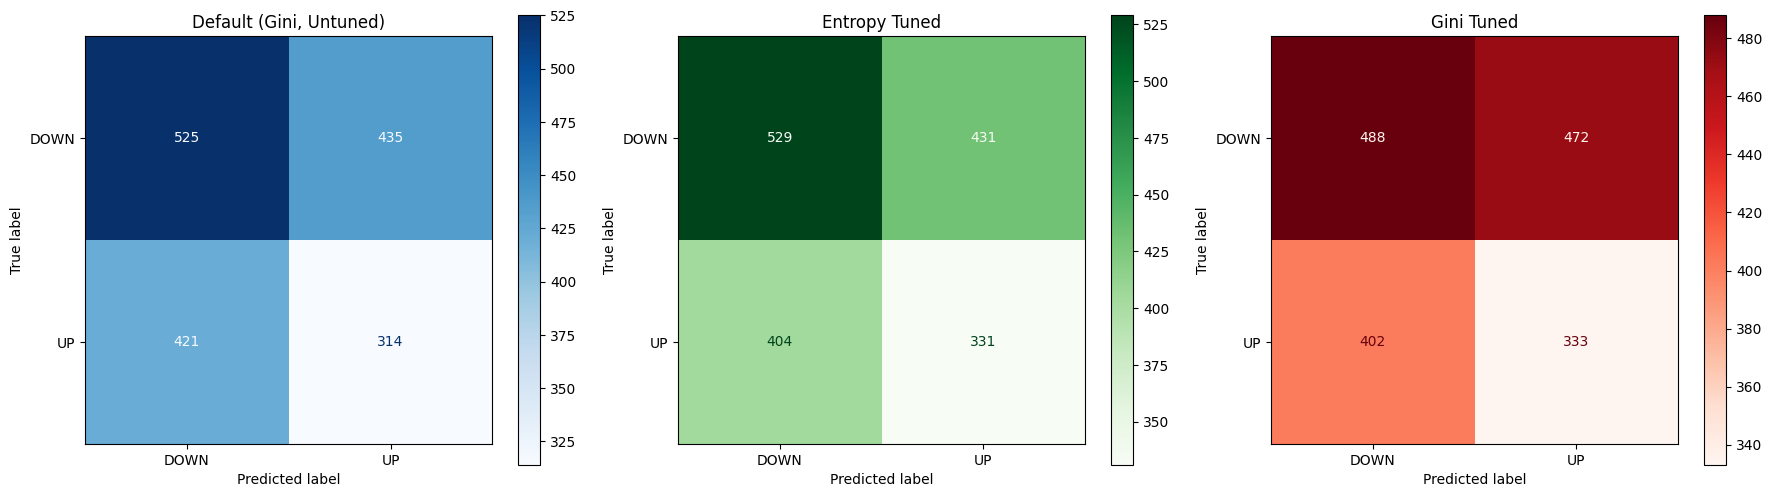

In [7]:
#Model 1: Decision Tree Classifier

#imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay

#Preproc
#sklearn DTs do not require removing NaN values, can handle categorical output data, and are not sensitive to the scale of the input variables
#no dropna, no label encoding (the features are all linear in this case), and no standardization / normalization
#DT may require feature selection to avoid overfitting or Dimension Reduction.

X = df_2.drop(columns=['Change'])
y = df_2['Change']

#Data Splitting
X_train_tts, X_test_tts, y_train_tts, y_test_tts = train_test_split(X, y, test_size=0.25, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tss = TimeSeriesSplit(n_splits=5)

#Training, Testing, Evaluating
dtrees = [DecisionTreeClassifier(random_state=42), DecisionTreeClassifier(random_state=42, criterion='entropy', class_weight='balanced', max_depth=15), DecisionTreeClassifier(random_state=42, criterion='gini', class_weight='balanced', max_depth=17) ]
scores = []
reports = []
splitScores = {
    'KFold': [],
    'StratifiedKFold': [],
    'TimeSeriesSplit': []
}
predicts = []
labels = ['Default (Gini, Untuned)','Entropy Tuned','Gini Tuned']

for model in dtrees:
    model.fit(X_train_tts, y_train_tts)
    y_pred = model.predict(X_test_tts)
    predicts.append(y_pred)
    score = accuracy_score(y_test_tts, y_pred)
    report = classification_report(y_test_tts, y_pred)
    splitScores['KFold'].append(cross_val_score(model, X, y, cv=kf, scoring='accuracy'))
    splitScores['StratifiedKFold'].append(cross_val_score(model, X, y, cv=skf, scoring='accuracy'))
    splitScores['TimeSeriesSplit'].append(cross_val_score(model, X, y, cv=tss, scoring='accuracy'))
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nTrainTestSplit: " ,scores[i],end='\n', sep='\t\t')
    print("KFold: ",np.mean(splitScores['KFold'][i]*100),end='\n', sep='\t\t\t\t\t')
    print("Stratified KFold: ",np.mean(splitScores['StratifiedKFold'][i]*100),end='\n', sep='\t\t')
    print("Time Series Split: ",np.mean(splitScores['TimeSeriesSplit'][i]*100),end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(dtrees)):
    ConfusionMatrixDisplay.from_estimator(dtrees[i], X_test_tts, y_test_tts, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#The Decision Tree struggled, between 51% and 54% accuracy. Since 50% is a coin flip, these models aren't very dependable. This
#stayed true even when switching between the splits. The Entropy Tuned Model showed a high f1 balance, but had a 50% accuracy, which is not better than a coin
#flip, it is also highly volatile as shown by the precision and recall values. As for the Default Model, it had a higher accuracy than Entropy, however
#overall, the Gini Tuned Model proved to be the most accurate with a somewhat balanced precision and recall for up and down. Even so, this model still was
#biased towards DOWN and had a relatively low accuracy.
#Therefore, one Decision Tree is NOT suitable for this dataset, hence the next model.

Default (Gini, Untuned)		
TrainTestSplit: 		54.572271386430685

               precision    recall  f1-score   support

        DOWN       0.58      0.74      0.65       960
          UP       0.46      0.30      0.36       735

    accuracy                           0.55      1695
   macro avg       0.52      0.52      0.50      1695
weighted avg       0.53      0.55      0.52      1695



Entropy Tuned		
TrainTestSplit: 		54.395280235988196

               precision    recall  f1-score   support

        DOWN       0.59      0.62      0.61       960
          UP       0.47      0.44      0.46       735

    accuracy                           0.54      1695
   macro avg       0.53      0.53      0.53      1695
weighted avg       0.54      0.54      0.54      1695



Gini Tuned		
TrainTestSplit: 		49.498525073746315

               precision    recall  f1-score   support

        DOWN       0.57      0.43      0.49       960
          UP       0.44      0.58      0.50       735

    ac

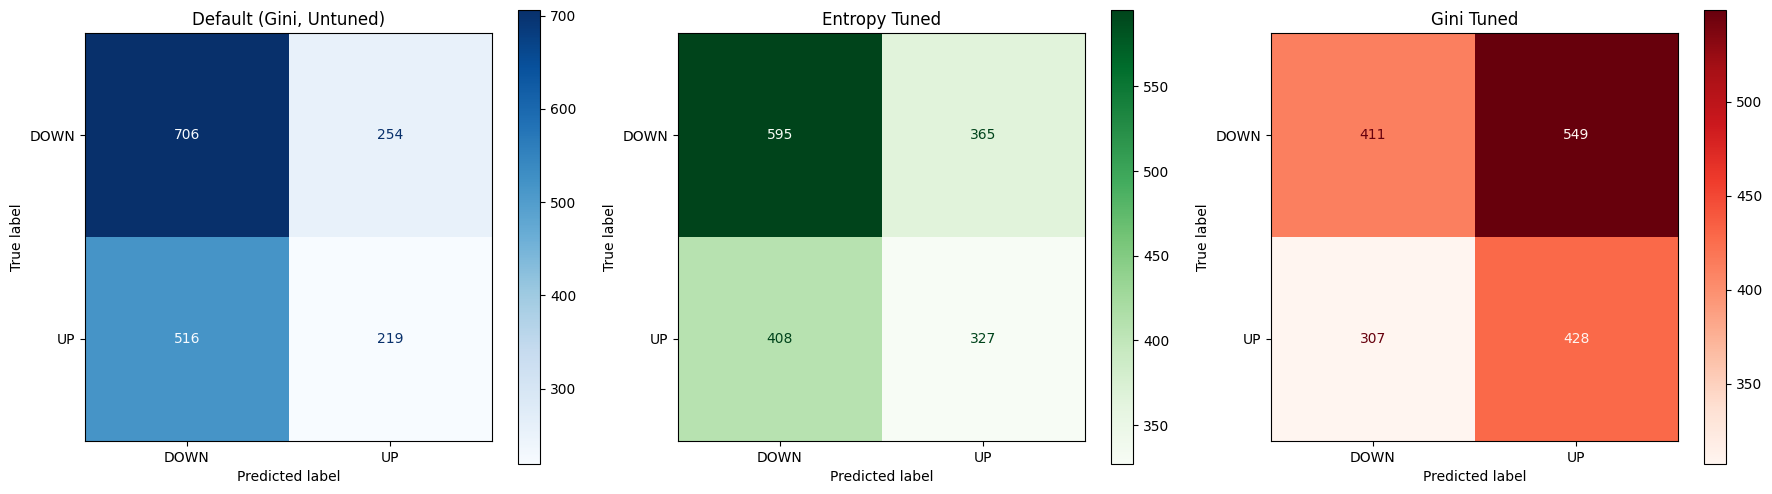

In [8]:
#Model 2: Random Forest
from sklearn.ensemble import RandomForestClassifier

#Preproc
#Identical to DT, none will be done. Same variables from dt will be used
#For the sake of saving run time, the other split methods will be removed (took approximately 6 minutes for each run when using multiple split methods)

#Training, Testing, Evaluating
rf=[RandomForestClassifier(random_state=42,n_estimators=200), RandomForestClassifier(random_state=42, criterion='entropy', class_weight='balanced', max_depth=10, n_estimators=150), RandomForestClassifier(random_state=42,criterion='gini',class_weight={'DOWN': 1, 'UP': 3.65},max_depth=20, n_estimators=1000)]

scores = []
reports = []
predicts = []

for model in rf:
    model.fit(X_train_tts, y_train_tts)
    y_pred = model.predict(X_test_tts)
    predicts.append(y_pred)
    score = accuracy_score(y_test_tts, y_pred)
    report = classification_report(y_test_tts, y_pred)
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nTrainTestSplit: " ,scores[i],end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(rf)):
    ConfusionMatrixDisplay.from_estimator(rf[i], X_test_tts, y_test_tts, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#The Random Forest models performed generally better than the Decision Tree models, yet they still struggled with accuracy, proving to also be an unsuitable choice for this dataset. While the untuned model had the highest accuracy, it had the worst balance, displaying heavy bias towards the DOWN as shown by the very low UP recall and precision values. As for the Tuned Entropy model, it tried to restore balance at the cost of accuracy, and only slightly succeeded. It had a 2% lower accuracy (avg) but was still relatively biased towards DOWN. Compared to the other models, the Tuned Gini model had the best balance by far, but the worst accuracy. It had almost no bias, making it more reliable than the others, but its accuracy is only slightly better than a coin flip.
#Therefore, the Tree and Ensemble models proved to be the wrong choice of models for this dataset, where the best possible one had only a slight increase over 50%, making it unreliable. More in depth analysis in the report.

KNN=3		
Accuracy: 		48.328267477203646

               precision    recall  f1-score   support

        DOWN       0.54      0.58      0.56       928
          UP       0.40      0.36      0.38       717

    accuracy                           0.48      1645
   macro avg       0.47      0.47      0.47      1645
weighted avg       0.48      0.48      0.48      1645



KNN=8		
Accuracy: 		50.15197568389058

               precision    recall  f1-score   support

        DOWN       0.55      0.62      0.58       928
          UP       0.42      0.35      0.38       717

    accuracy                           0.50      1645
   macro avg       0.48      0.48      0.48      1645
weighted avg       0.49      0.50      0.49      1645



KNN=Sqrt of length		
Accuracy: 		55.075987841945285

               precision    recall  f1-score   support

        DOWN       0.57      0.88      0.69       928
          UP       0.45      0.13      0.20       717

    accuracy                           0.55

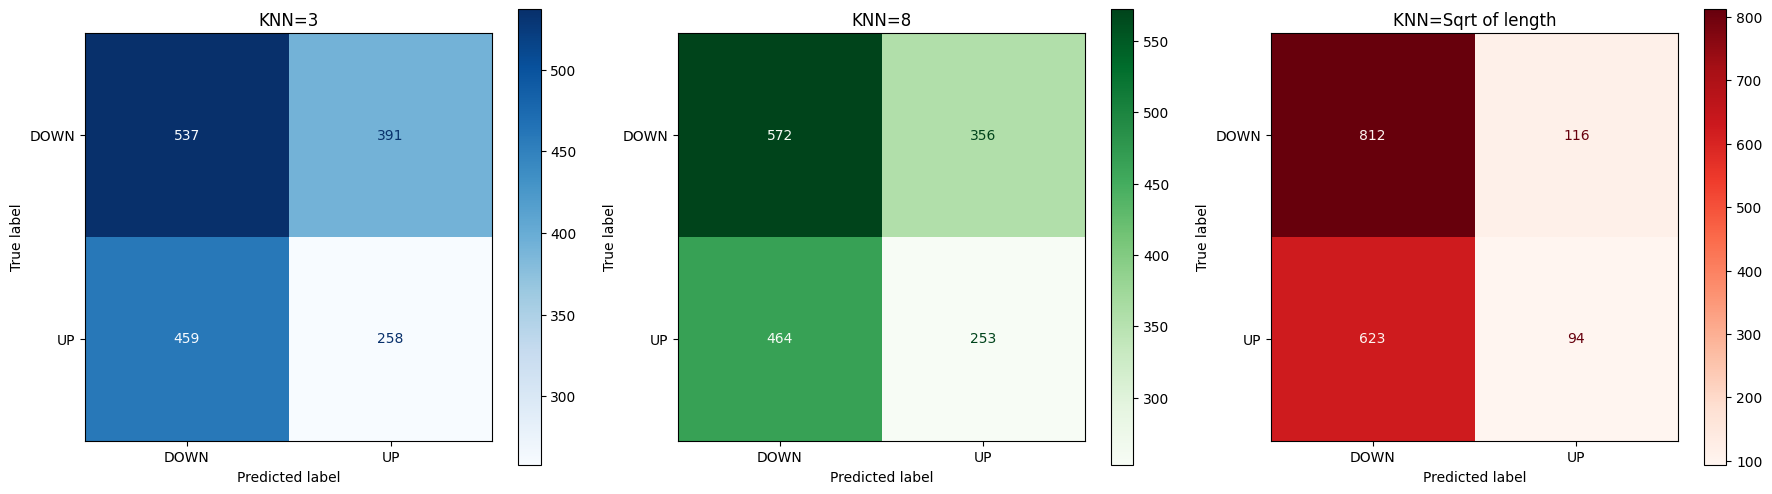

In [9]:
#Model 3: K-Nearest Neighbors
#(Can't use Naive Bayes due to the assumption of independence)

#Preproc
# KNN requires removing null values
dfKnn = df_2.copy().dropna()
X = dfKnn.drop(columns=['Change'])
y = dfKnn['Change']

# KNN doesn't work well with high number of features, so we need to do dimension reduction. PCA in this case. Also, KNN requires scaling
#   1. splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#   2. scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#   3. pca
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# As for outliers, this dataset doesn't actually have any outliers. Any large increases or decreases are meant to be kept and not removed

#Training, Testing, and Evaluating
from sklearn.neighbors import KNeighborsClassifier
import math
knn = [KNeighborsClassifier(weights='distance',n_neighbors=3), KNeighborsClassifier(weights='distance',n_neighbors=8), KNeighborsClassifier(weights='distance',n_neighbors=math.ceil(math.sqrt(len(X_train))))]
labels = ['KNN=3','KNN=8', 'KNN=Sqrt of length']
predicts = []
scores = []
reports = []

for model in knn:
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    predicts.append(y_pred)
    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nAccuracy: " ,scores[i],end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(knn)):
    ConfusionMatrixDisplay.from_estimator(knn[i], X_test_pca, y_test, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#KNN struggled with this dataset, proving once more how difficult this prediction is. The Sqrt of length model had the highest accuracy between the 3 models, and even higher than the tree and ensemble models, but it had a shockingly low recall for UP (15%), this means that this model is most likely lazy and going for the easy approach of choosing DOWN almost always. This is backed up even more by its Confusion Matrix, where we see that it didn't even predict that many UPs compared to down. As for the N=3 model, its balance wasn't too bad, however its accuracy is only 1% better than a coin flip. Finally, the N=8 model as expected ended up in the middle, with accuracy of ~54% and a lower balance than the first model.
#Overall this model seems to generally struggle between balance and accuracy, sacrificing one for the other as the K changes. It seems no matter what that number is, the previous models still were generally better than KNN, proving that this model is not suitable for this dataset.

Default (RBF)		
Accuracy: 		55.92705167173252

               precision    recall  f1-score   support

        DOWN       0.57      0.94      0.71       928
          UP       0.46      0.07      0.12       717

    accuracy                           0.56      1645
   macro avg       0.51      0.50      0.41      1645
weighted avg       0.52      0.56      0.45      1645



Balanced Linear		
Accuracy: 		55.379939209726444

               precision    recall  f1-score   support

        DOWN       0.57      0.83      0.68       928
          UP       0.47      0.19      0.27       717

    accuracy                           0.55      1645
   macro avg       0.52      0.51      0.48      1645
weighted avg       0.53      0.55      0.50      1645



Balanced RBF		
Accuracy: 		52.70516717325228

               precision    recall  f1-score   support

        DOWN       0.57      0.62      0.60       928
          UP       0.45      0.40      0.43       717

    accuracy                    

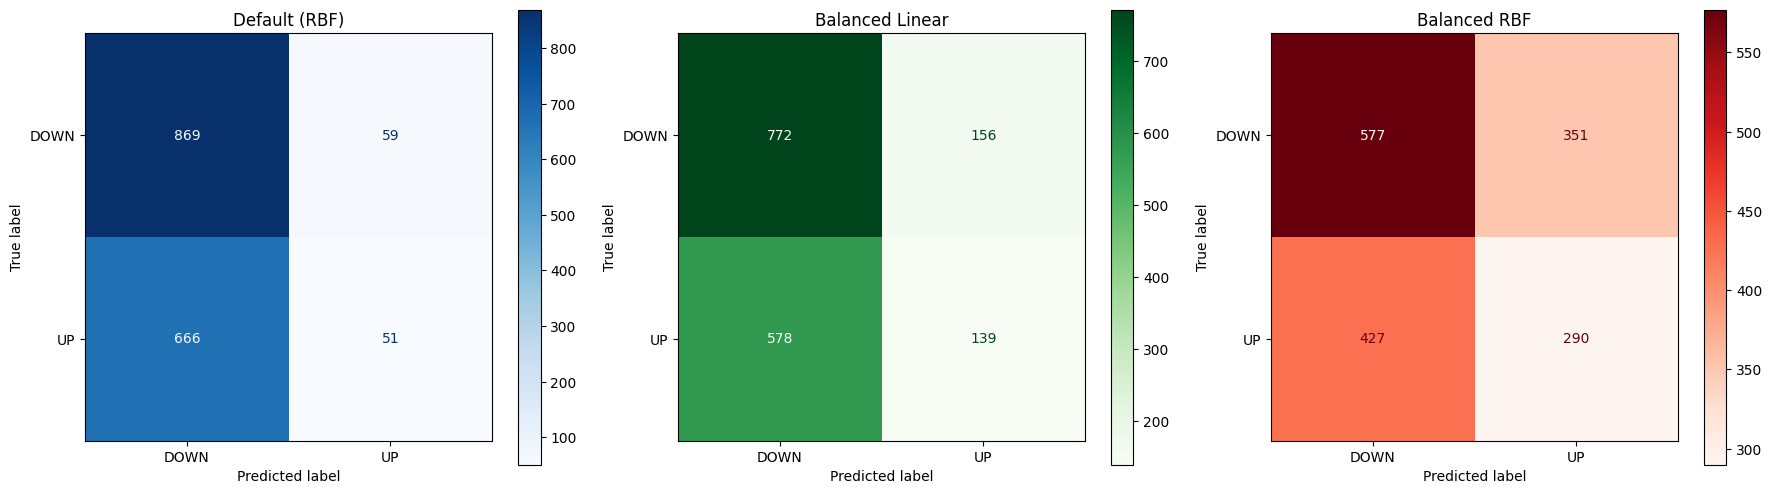

In [10]:
#Model 4: Support Vector Machine
#For Preproc; SVM, like KNN, requires scaling and reduction. Due to same preproc, the same variables will be used.

#Training, Testing, and Evaluating
from sklearn.svm import SVC #Support Vector Classifier
svm = [SVC(random_state=42), SVC(random_state=42,kernel='linear', class_weight='balanced'), SVC(random_state=42,kernel='rbf', class_weight='balanced')]
labels = ['Default (RBF)','Balanced Linear', 'Balanced RBF']
predicts = []
scores = []
reports = []

for model in svm:
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    predicts.append(y_pred)
    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nAccuracy: " ,scores[i],end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(svm)):
    ConfusionMatrixDisplay.from_estimator(svm[i], X_test_pca, y_test, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#Finally it seems this model actually reached a reliable result. The default RBF model, had very low recall for down, making it another lazy unreliable model (always predicts down, giving high accuracy). As for the Balanced Linear model, it raised the recall for up a bit, but is still unreliable and predicts DOWN way too often as proven by the numbers on the confusion matrix, this makes sense as the features are non-linear. And finally, the Balanced RBF model gave a respectable 55.5~% accuracy and a reasonable UP recall at 47. This does mean that this model is always a bit biased towards DOWN, but it is much better than the other SVMs.
#Overall, this model proved to be the best between all the tested models for this dataset.

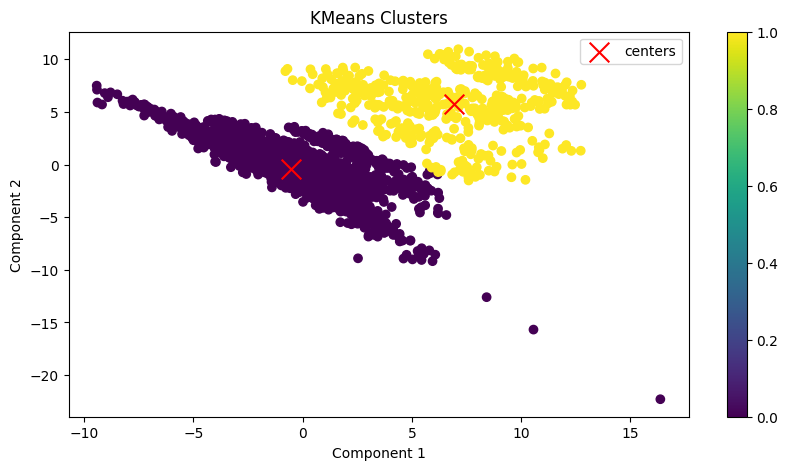

Cluster     0    1
Actual            
DOWN     3463  261
UP       2630  225
56591.39850494988


In [11]:
#Bonus Model: K-Means (Unsupervised, Clustering)
#We decided to try K-Means out of curiosity to the resulting clusters. Expected outcome: similar to KNN
# K-Means is best with scaling and reduction

#Training and Testing
dfKm = df_2.copy().dropna()
X = dfKm.drop(columns=['Change'])
from sklearn.cluster import KMeans
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
km = KMeans(n_clusters=2, random_state=42) #2 clusters will be used for now
clusters = km.fit_predict(X_pca)
centers = km.cluster_centers_

#Plot
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', s=200, label='centers')
plt.title('KMeans Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.colorbar()
plt.show()

#Results
print(pd.crosstab(dfKm['Change'], clusters, rownames=['Actual'], colnames=['Cluster']))
print(km.inertia_)

#Conclusion 1: The extremely high inertia (almost 57 thousand) and the imbalanced results between Cluster 0 and Cluster 1 (they aren't 0 = UPs and 1=DOWNs) proves that this dataset doesn't have a straight predictable pattern for the supervised models to follow, hence why most of them struggled in both accuracy and balance. This result happened when using 2 clusters, which is the same number as classes. What would the results be had we tried the optimal K using the elbow curve?


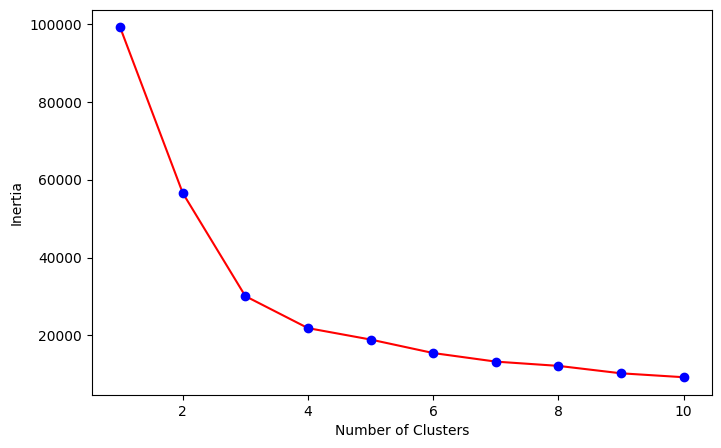

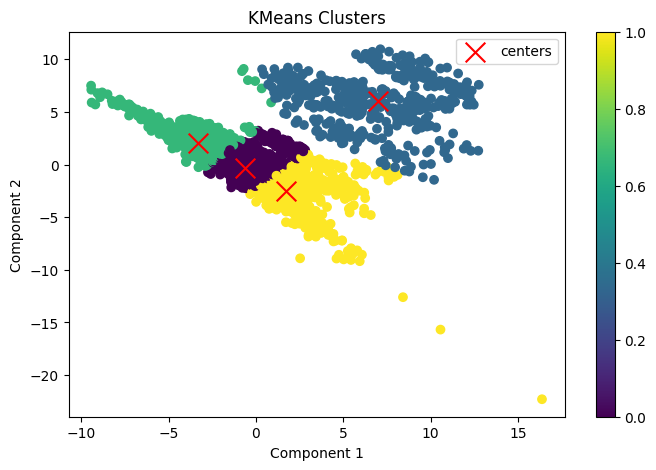

Cluster     0    1    2     3
Actual                       
DOWN     1740  248  726  1010
UP       1321  213  599   722
21890.68569709873


In [25]:
#Bonus Model: Unsupervised Learning, K-Means, Part 2

#The Elbow Curve
#   1. Getting the inertia values
k_range = range(1,11) #1 to 10
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)

#   2. Plotting it
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, '-',color='red')
plt.plot(k_range, inertia, 'o',color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

#The elbow curve showed k=4
#Plotting the Clusters
km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(X_pca)
centers = km.cluster_centers_
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', s=200, label='centers')
plt.title('KMeans Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.colorbar()
plt.show()

#Results
print(pd.crosstab(dfKm['Change'], clusters, rownames=['Actual'], colnames=['Cluster']))
print(km.inertia_)

#Conclusion 2: The resulting inertia was still very high, and the crosstabulated results didn't show any distinction between UP and DOWN. While this may be a negative result, it confirmed that the problem was never with the models used, it was the dataset. This dataset proved to be very difficult for the models to find any patterns and predict accurate results. This further enforced how difficult stock price prediction is, even for the best ML models.


In [ ]:
#Finally, throughout this project, we've learned that not all problems can be easily solved using simple machine learning code. Instead, we had to manually fine-tune each model and do extensive testing. Even then, we didn't seem to get satisfying results. Trees struggled, ensembles struggled, distance-based models struggled, unsupervised clustering struggled, and even margin-based models, which gave the best results, still struggled. The limitation lies in the dataset's signal, not the choice of model.